In [2]:
!pip install pandas matplotlib seaborn jupyter

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 31.8 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 34.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 26.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 31.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 33.1 MB/s  0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.6 MB/s  0:00:00eta 0:00:01
 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries loaded successfully 🎉")

Matplotlib is building the font cache; this may take a moment.


Libraries loaded successfully 🎉


In [1]:
!which python

/Users/saulerub/Documents/global-labor-compliance-dashboard/.venv/bin/python


In [5]:
from pathlib import Path
import pandas as pd

RAW = Path("../data/raw")   # from notebooks/ up one level, then data/raw

# helper: pick the most recent file that starts with a prefix
def latest_csv(prefix: str) -> Path:
    files = sorted(RAW.glob(f"{prefix}*.csv"))
    if not files:
        raise FileNotFoundError(f"No files matching {prefix}*.csv in {RAW.resolve()}")
    return files[-1]

lf_file   = latest_csv("EAP_TEAP_SEX_AGE_NB_A")   # labour force
unemp_file= latest_csv("UNE_TUNE_SEX_AGE_NB_A")   # unemployment

lf_file, unemp_file

(PosixPath('../data/raw/EAP_TEAP_SEX_AGE_NB_A-20250819T1611.csv'),
 PosixPath('../data/raw/UNE_TUNE_SEX_AGE_NB_A-20250819T1613.csv'))

In [6]:
# Load the CSVs
lf = pd.read_csv(lf_file, encoding="utf-8-sig", low_memory=False)
unemp = pd.read_csv(unemp_file, encoding="utf-8-sig", low_memory=False)

# Inspect shapes
print("Labour force shape:", lf.shape)
print("Unemployment shape:", unemp.shape)

# Preview first few rows
lf.head(3)

Labour force shape: (351749, 11)
Unemployment shape: (319338, 11)


,ref_area.label,source.label,indicator.label,sex.label,classif1.label,time,obs_value,obs_status.label,note_classif.label,note_indicator.label,note_source.label
0,Aruba,LFS - Labour Force Survey,Labour force by sex and age (thousands),Total,"Age (Youth, adults): 15+",2011,52.585,NaN,NaN,NaN,NaN
1,Aruba,LFS - Labour Force Survey,Labour force by sex and age (thousands),Total,"Age (Youth, adults): 15-64",2011,51.761,NaN,NaN,NaN,NaN
2,Aruba,LFS - Labour Force Survey,Labour force by sex and age (thousands),Total,"Age (Youth, adults): 15-24",2011,4.698,NaN,NaN,NaN,NaN


In [7]:
lf.columns.tolist()

['ref_area.label',
 'source.label',
 'indicator.label',
 'sex.label',
 'classif1.label',
 'time',
 'obs_value',
 'obs_status.label',
 'note_classif.label',
 'note_indicator.label',
 'note_source.label']

In [8]:
import pandas as pd

# map ILO "with labels" columns -> tidy schema
def normalize_ilo(df, dataset_name):
    colmap = {
        "ref_area.label": "country",
        "time": "year",
        "sex.label": "sex",
        "classif1.label": "age",   # this column carries the age bands
        "obs_value": "value",
        "indicator.label": "indicator",
        "source.label": "source",
    }
    df = df.rename(columns={c: colmap.get(c, c) for c in df.columns})
    # keep only what we need if present
    keep = [c for c in ["country","year","sex","age","value","indicator","source"] if c in df.columns]
    out = df[keep].copy()

    # types & cleaning
    out["year"] = pd.to_numeric(out["year"], errors="coerce")
    out["value"] = pd.to_numeric(out["value"], errors="coerce")
    out["dataset"] = dataset_name
    out = out.dropna(subset=["year", "value"])
    return out

lf_clean = normalize_ilo(lf, "labour_force")
unemp_clean = normalize_ilo(unemp, "unemployment")

lf_clean.head(3), unemp_clean.head(3), lf_clean.shape, unemp_clean.shape

(  country  year    sex                         age   value  \
 0   Aruba  2011  Total    Age (Youth, adults): 15+  52.585   
 1   Aruba  2011  Total  Age (Youth, adults): 15-64  51.761   
 2   Aruba  2011  Total  Age (Youth, adults): 15-24   4.698   
 
                                  indicator                     source  \
 0  Labour force by sex and age (thousands)  LFS - Labour Force Survey   
 1  Labour force by sex and age (thousands)  LFS - Labour Force Survey   
 2  Labour force by sex and age (thousands)  LFS - Labour Force Survey   
 
         dataset  
 0  labour_force  
 1  labour_force  
 2  labour_force  ,
   country  year    sex                         age  value  \
 0   Aruba  2010  Total    Age (Youth, adults): 15+  5.519   
 1   Aruba  2010  Total  Age (Youth, adults): 15-64  5.433   
 2   Aruba  2010  Total  Age (Youth, adults): 15-24  1.345   
 
                                  indicator  \
 0  Unemployment by sex and age (thousands)   
 1  Unemployment by sex and

In [9]:
from pathlib import Path

SAMPLE = Path("../data/sample")
SAMPLE.mkdir(parents=True, exist_ok=True)

countries = ["United States","United Kingdom","Germany","France","Israel","Lithuania"]

lf_sample = lf_clean[lf_clean["country"].isin(countries) & (lf_clean["year"] >= 2010)].copy()
unemp_sample = unemp_clean[unemp_clean["country"].isin(countries) & (unemp_clean["year"] >= 2010)].copy()

lf_sample.to_csv(SAMPLE / "labour_force_sample.csv", index=False)
unemp_sample.to_csv(SAMPLE / "unemployment_sample.csv", index=False)

lf_sample.shape, unemp_sample.shape, (SAMPLE / "labour_force_sample.csv").exists(), (SAMPLE / "unemployment_sample.csv").exists()

((4524, 8), (4458, 8), True, True)

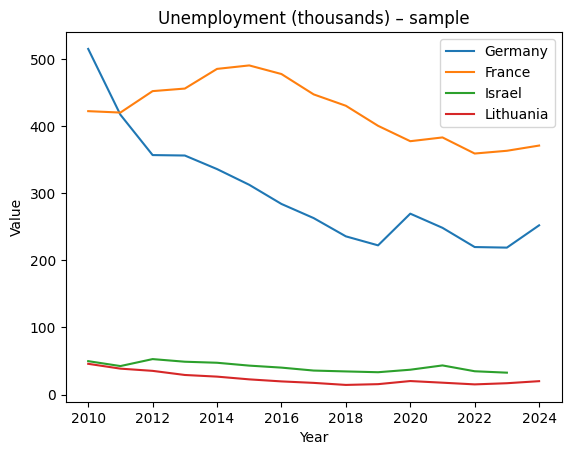

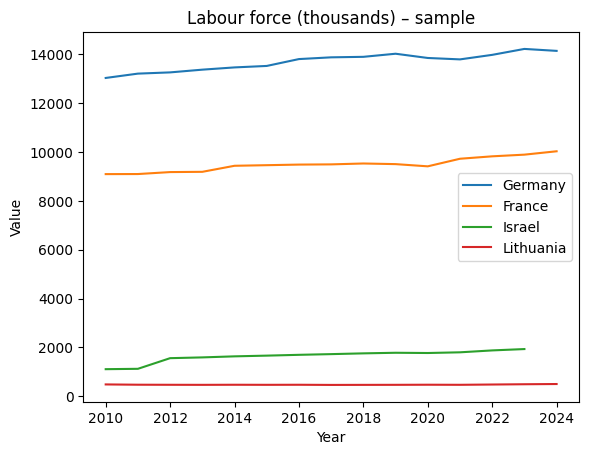

In [10]:
import matplotlib.pyplot as plt

def lineplot(df, title):
    for c in df["country"].unique():
        d = df[df["country"]==c].groupby("year", as_index=False)["value"].mean().sort_values("year")
        plt.plot(d["year"], d["value"], label=c)
    plt.title(title); plt.xlabel("Year"); plt.ylabel("Value")
    plt.legend(); plt.show()

lineplot(unemp_sample[unemp_sample["sex"].isin(["Male","Female"])], "Unemployment (thousands) – sample")
lineplot(lf_sample[lf_sample["sex"]=="Total"], "Labour force (thousands) – sample")

In [11]:
#rename

rename_map = {
    "ref_area.label": "country",
    "time": "year",
    "obs_value": "value",
    "sex.label": "sex",
    "classif1.label": "age_group",
    "indicator.label": "indicator"
}
lf.rename(columns=rename_map, inplace=True)
unemp.rename(columns=rename_map, inplace=True)

In [12]:
merged = pd.merge(
    lf, unemp,
    on=["country", "year", "sex", "age_group"],
    suffixes=("_lf", "_unemp")
)

In [13]:
merged["unemployment_rate"] = (
    merged["value_unemp"] / merged["value_lf"] * 100
)

In [15]:
merged.isna().any().any()

np.True_

In [16]:
merged.isna().sum()

country                            0
source.label_lf                    0
indicator_lf                       0
sex                                0
age_group                          0
year                               0
value_lf                          20
obs_status.label_lf           268864
note_classif.label_lf         281410
note_indicator.label_lf       266441
note_source.label_lf           19021
source.label_unemp                 0
indicator_unemp                    0
value_unemp                    12021
obs_status.label_unemp        246637
note_classif.label_unemp      279341
note_indicator.label_unemp    246327
note_source.label_unemp        16357
unemployment_rate              12043
dtype: int64

In [17]:
# Drop rows where core values are missing
merged = merged.dropna(subset=["value_lf", "value_unemp", "unemployment_rate"])

# Drop metadata columns
merged = merged[["country", "year", "sex", "age_group", "value_lf", "value_unemp", "unemployment_rate"]]

In [18]:
merged.shape

(275260, 7)

In [19]:
merged.duplicated().sum()

np.int64(0)

In [20]:
merged["country"].unique()
merged["year"].min(), merged["year"].max()
merged["sex"].unique()
merged["age_group"].unique()

array(['Age (Youth, adults): 15+', 'Age (Youth, adults): 15-64',
       'Age (Youth, adults): 15-24', 'Age (Youth, adults): 25+',
       'Age (Aggregate bands): Total', 'Age (Aggregate bands): 15-24',
       'Age (Aggregate bands): 25-54', 'Age (Aggregate bands): 55-64',
       'Age (Aggregate bands): 65+', 'Age (10-year bands): Total',
       'Age (10-year bands): 15-24', 'Age (10-year bands): 25-34',
       'Age (10-year bands): 35-44', 'Age (10-year bands): 45-54',
       'Age (10-year bands): 55-64', 'Age (10-year bands): 65+',
       'Age (5-year bands): Total', 'Age (5-year bands): 15-19',
       'Age (5-year bands): 20-24', 'Age (5-year bands): 25-29',
       'Age (5-year bands): 30-34', 'Age (5-year bands): 35-39',
       'Age (5-year bands): 40-44', 'Age (5-year bands): 45-49',
       'Age (5-year bands): 50-54', 'Age (5-year bands): 55-59',
       'Age (5-year bands): 60-64', 'Age (5-year bands): 65+',
       'Age (Aggregate bands): <15', 'Age (10-year bands): <15',
       'A

In [21]:
merged.head()
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275260 entries, 0 to 287302
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   country            275260 non-null  object 
 1   year               275260 non-null  int64  
 2   sex                275260 non-null  object 
 3   age_group          275260 non-null  object 
 4   value_lf           275260 non-null  float64
 5   value_unemp        275260 non-null  float64
 6   unemployment_rate  275260 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 16.8+ MB


In [22]:
#Normilising age group

import re
import pandas as pd
from pathlib import Path

def normalize_age_label(s: str) -> str | None:
    if pd.isna(s):
        return None
    s = str(s)
    # unify dashes and strip the leading "Age (...): "
    s = s.replace("–", "-")
    s = re.sub(r"^Age\s*\([^)]+\):\s*", "", s).strip()  # -> "Total", "15-24", "65+", "<15", etc.

    # tidy spaces like "65 +" -> "65+"
    s = re.sub(r"\s*\+\s*$", "+", s)
    s = re.sub(r"\s*-\s*", "-", s)

    # normalize 'total'
    if s.lower().startswith("total"):
        return "Total"
    return s

merged["age_group_clean"] = merged["age_group"].map(normalize_age_label)
merged["age_group_clean"].unique()[:20]

array(['15+', '15-64', '15-24', '25+', 'Total', '25-54', '55-64', '65+',
       '25-34', '35-44', '45-54', '15-19', '20-24', '25-29', '30-34',
       '35-39', '40-44', '45-49', '50-54', '55-59'], dtype=object)

In [24]:
merged["age_group_clean"].unique()[:20]

array(['15+', '15-64', '15-24', '25+', 'Total', '25-54', '55-64', '65+',
       '25-34', '35-44', '45-54', '15-19', '20-24', '25-29', '30-34',
       '35-39', '40-44', '45-49', '50-54', '55-59'], dtype=object)

In [25]:
#Country–Year Totals

totals = (
    merged
    .loc[
        (merged["sex"] == "Total") & 
        (merged["age_group_clean"] == "Total")
    ]
    [["country", "year", "unemployment_rate", "value_lf", "value_unemp"]]
    .sort_values(["country", "year"])
    .reset_index(drop=True)
)

# quick check
print(totals.shape)
totals.head()

(10571, 5)


,country,year,unemployment_rate,value_lf,value_unemp
0,Afghanistan,2008,2.494474,7678.092,191.528
1,Afghanistan,2008,2.494474,7678.092,191.528
2,Afghanistan,2008,2.494474,7678.092,191.528
3,Afghanistan,2012,1.691919,6530.100,110.484
4,Afghanistan,2012,1.691919,6530.100,110.484


In [26]:
# how many unique countries?
print("Countries:", totals["country"].nunique())
print("Years:", totals["year"].nunique())

# peek at some random rows (not just the first)
totals.sample(10, random_state=42)

Countries: 216
Years: 78


,country,year,unemployment_rate,value_lf,value_unemp
1284,Brazil,2021,13.158527,105004.777,13817.082
6992,Paraguay,2002,9.392963,2314.882,217.436
9622,Trinidad and Tobago,2013,2.683448,643.575,17.270
10063,United States of America,1961,6.690416,70459.000,4714.000
1393,Bulgaria,2022,4.147997,3067.842,127.254
10054,United States of America,1958,6.803767,67639.000,4602.000
318,Australia,1990,6.926160,8443.640,584.820
6925,Panama,2011,3.921864,1600.795,62.781
733,Barbados,1992,22.996795,124.800,28.700
1509,Cambodia,2023,0.255876,9781.317,25.028


In [29]:
# Inspect Duplicates

ten_bands = ["15-24","25-34","35-44","45-54","55-64","65+"]

cand = (
    merged.loc[
        (merged["sex"] == "Total") &
        (merged["age_group_clean"].isin(ten_bands)),
        ["country","year","age_group_clean","value_lf","value_unemp"]
    ]
)

# show a few duplicated keys to convince ourselves
dups = cand[cand.duplicated(["country","year","age_group_clean"], keep=False)]\
           .sort_values(["country","year","age_group_clean"])
dups.head(20)

,country,year,age_group_clean,value_lf,value_unemp
690,Afghanistan,2008,15-24,2166.557,87.718
701,Afghanistan,2008,15-24,2166.557,87.718
716,Afghanistan,2008,15-24,2166.557,87.718
703,Afghanistan,2008,55-64,537.967,13.358
720,Afghanistan,2008,55-64,537.967,13.358
704,Afghanistan,2008,65+,253.533,10.155
721,Afghanistan,2008,65+,253.533,10.155
747,Afghanistan,2008,65+,253.533,10.155
606,Afghanistan,2012,15-24,1979.815,58.063
617,Afghanistan,2012,15-24,1979.815,58.063


In [30]:
# Deduplicate by grouping, then compute rate

ten_bands = ["15-24","25-34","35-44","45-54","55-64","65+"]

cand = (
    merged.loc[
        (merged["sex"] == "Total") &
        (merged["age_group_clean"].isin(ten_bands)),
        ["country","year","age_group_clean","value_lf","value_unemp"]
    ]
)

age10 = (
    cand
    .groupby(["country","year","age_group_clean"], as_index=False)
    .agg({"value_lf":"sum", "value_unemp":"sum"})          # collapses those dupes
    .rename(columns={"age_group_clean":"age_band"})
)

age10["unemployment_rate"] = (age10["value_unemp"] / age10["value_lf"]) * 100

# sanity
assert not age10.duplicated(["country","year","age_band"]).any()
print(age10.shape)
age10.head()

(19875, 6)


,country,year,age_band,value_lf,value_unemp,unemployment_rate
0,Afghanistan,2008,15-24,6499.671,263.154,4.048728
1,Afghanistan,2008,25-34,2064.875,38.213,1.850620
2,Afghanistan,2008,35-44,1606.669,24.577,1.529687
3,Afghanistan,2008,45-54,1048.491,17.507,1.669733
4,Afghanistan,2008,55-64,1075.934,26.716,2.483052


In [31]:
# Check a couple of countries/years look sensible
age10.query("country == 'Afghanistan' and year in [2008, 2012, 2014]")\
     .sort_values(["year","age_band"]).head(12)

# Make sure all six 10‑year bands appear (some countries/years may not)
age10.groupby(["country","year"])["age_band"].nunique().value_counts().head()

age_band
6    2418
5     905
4     130
1     116
3      42
Name: count, dtype: int64

In [32]:
# map messy bands into clean 10-year buckets
band_map = {
    "15-19": "15-24", "20-24": "15-24",
    "25-29": "25-34", "30-34": "25-34",
    "35-39": "35-44", "40-44": "35-44",
    "45-49": "45-54", "50-54": "45-54",
    "55-59": "55-64", "60-64": "55-64",
    "15-24": "15-24", "25-34": "25-34",
    "35-44": "35-44", "45-54": "45-54",
    "55-64": "55-64", "65+": "65+",
    "Total": "Total"
}

merged["age_band"] = merged["age_group_clean"].map(band_map)

In [33]:
print(merged["age_band"].unique())

[nan '15-24' 'Total' '55-64' '65+' '25-34' '35-44' '45-54']


In [34]:
# collapse into final 10-year age bands dataset
age10 = (
    merged.loc[merged["sex"] == "Total"]  # only keep totals
    .dropna(subset=["age_band"])          # remove rows that didn’t map
    .groupby(["country", "year", "age_band"], as_index=False)
    .agg({"value_lf":"sum", "value_unemp":"sum"})
)

# compute unemployment rate
age10["unemployment_rate"] = age10["value_unemp"] / age10["value_lf"] * 100

# sanity check
print(age10.shape)
print(age10.head())

(23709, 6)
       country  year age_band  value_lf  value_unemp  unemployment_rate
0  Afghanistan  2008    15-24  8666.228      350.872           4.048728
1  Afghanistan  2008    25-34  4129.750       76.426           1.850620
2  Afghanistan  2008    35-44  3213.338       49.154           1.529687
3  Afghanistan  2008    45-54  2096.982       35.014           1.669733
4  Afghanistan  2008    55-64  1613.901       40.074           2.483052


In [35]:
# every (country, year, age_band) should be unique
assert not age10.duplicated(["country","year","age_band"]).any()

In [36]:
order = ["15-24","25-34","35-44","45-54","55-64","65+"]
age10["age_band"] = pd.Categorical(age10["age_band"], order, ordered=True)
age10 = age10.sort_values(["country","year","age_band"]).reset_index(drop=True)

In [37]:
from pathlib import Path
PROC = Path("../data/processed")
PROC.mkdir(parents=True, exist_ok=True)

# A) Country–Year totals (you already created it earlier as `totals`)
totals.to_csv(PROC / "totals_country_year.csv", index=False)

# B) Country–Year–Age (10-year bands, sex=Total)
age10.to_csv(PROC / "age10_country_year_age.csv", index=False)

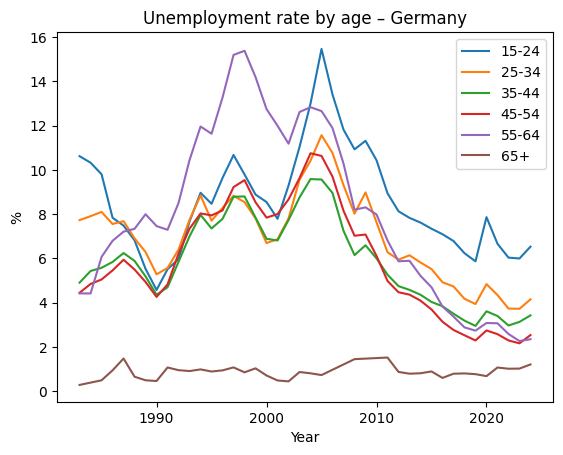

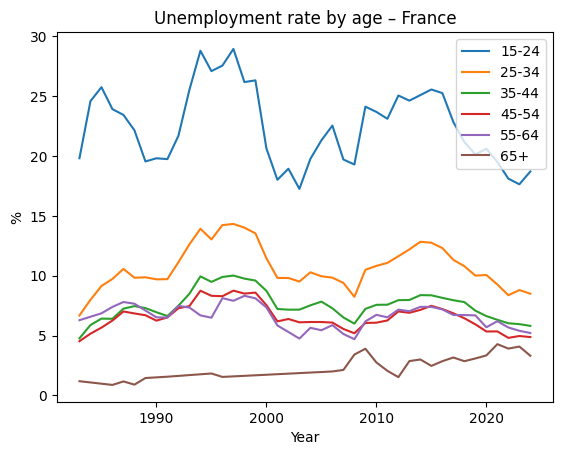

In [38]:
import matplotlib.pyplot as plt

def lines(df, ctry):
    tmp = df[df["country"]==ctry]
    for band in tmp["age_band"].cat.categories:
        t = tmp[tmp["age_band"]==band]
        if len(t): plt.plot(t["year"], t["unemployment_rate"], label=band)
    plt.title(f"Unemployment rate by age – {ctry}")
    plt.xlabel("Year"); plt.ylabel("%"); plt.legend(); plt.show()

lines(age10, "Germany")
lines(age10, "France")

In [39]:
from pathlib import Path
import pandas as pd

PROC = Path("../data/processed")

# List everything in the folder
print(list(PROC.glob("*.csv")))

# Quick peek at each file
print("\n--- Totals ---")
print(pd.read_csv(PROC / "totals_country_year.csv").head())

print("\n--- Age bands ---")
print(pd.read_csv(PROC / "age10_country_year_age.csv").head())

[PosixPath('../data/processed/totals_country_year.csv'), PosixPath('../data/processed/age10_country_year_age.csv')]

--- Totals ---
       country  year  unemployment_rate  value_lf  value_unemp
0  Afghanistan  2008           2.494474  7678.092      191.528
1  Afghanistan  2008           2.494474  7678.092      191.528
2  Afghanistan  2008           2.494474  7678.092      191.528
3  Afghanistan  2012           1.691919  6530.100      110.484
4  Afghanistan  2012           1.691919  6530.100      110.484

--- Age bands ---
       country  year age_band  value_lf  value_unemp  unemployment_rate
0  Afghanistan  2008    15-24  8666.228      350.872           4.048728
1  Afghanistan  2008    25-34  4129.750       76.426           1.850620
2  Afghanistan  2008    35-44  3213.338       49.154           1.529687
3  Afghanistan  2008    45-54  2096.982       35.014           1.669733
4  Afghanistan  2008    55-64  1613.901       40.074           2.483052


In [40]:
from pathlib import Path
import pandas as pd

PROC = Path("../data/processed").resolve()

# these are the two DataFrames you built earlier
# 'totals' -> country-year totals
# 'age10'  -> country-year-10yr-age bands (six bands)

# 1) Save
totals_file = PROC / "totals_country_year.csv"
age10_file  = PROC / "age10_country_year_age.csv"

totals.to_csv(totals_file, index=False)
age10.to_csv(age10_file, index=False)

# 2) Verify headers + a few rows
print("Totals path:", totals_file)
print(pd.read_csv(totals_file, nrows=3))

print("\nAge10 path:", age10_file)
print(pd.read_csv(age10_file, nrows=3))

Totals path: /Users/saulerub/Documents/global-labor-compliance-dashboard/data/processed/totals_country_year.csv
       country  year  unemployment_rate  value_lf  value_unemp
0  Afghanistan  2008           2.494474  7678.092      191.528
1  Afghanistan  2008           2.494474  7678.092      191.528
2  Afghanistan  2008           2.494474  7678.092      191.528

Age10 path: /Users/saulerub/Documents/global-labor-compliance-dashboard/data/processed/age10_country_year_age.csv
       country  year age_band  value_lf  value_unemp  unemployment_rate
0  Afghanistan  2008    15-24  8666.228      350.872           4.048728
1  Afghanistan  2008    25-34  4129.750       76.426           1.850620
2  Afghanistan  2008    35-44  3213.338       49.154           1.529687


In [42]:
# lf_clean and unemp_clean already exist from your earlier steps.

# 1) Pick only the fields we need and align column names
lf = (
    lf_clean
    .rename(columns={
        "age": "age_group",        # if you already have 'age_group', this is a no-op
        "value": "value_lf",
        "source": "source_lf",
    })
    [["country","year","sex","age_group","value_lf","source_lf"]]
)

un = (
    unemp_clean
    .rename(columns={
        "age": "age_group",        # if you already have 'age_group', this is a no-op
        "value": "value_unemp",
        "source": "source_unemp",
    })
    [["country","year","sex","age_group","value_unemp","source_unemp"]]
)

# 2) Merge on the aligned keys
merged = (
    lf.merge(
        un,
        on=["country","year","sex","age_group"],
        how="inner"
    )
)

# 3) Compute rate and keep columns (including sources!)
merged["unemployment_rate"] = merged["value_unemp"] / merged["value_lf"] * 100
merged = merged[
    ["country","year","sex","age_group",
     "value_lf","value_unemp","unemployment_rate",
     "source_lf","source_unemp"]
].copy()

# 4) Normalize the age label you already defined earlier
merged["age_group_clean"] = merged["age_group"].map(normalize_age_label)

print(merged.shape)
merged.head()

(275282, 10)


,country,year,sex,age_group,value_lf,value_unemp,unemployment_rate,source_lf,source_unemp,age_group_clean
0,Aruba,2010,Total,"Age (Youth, adults): 15+",52.043,5.519,10.604692,PC - Population and Housing Census,PC - Population and Housing Census,15+
1,Aruba,2010,Total,"Age (Youth, adults): 15-64",50.877,5.433,10.678696,PC - Population and Housing Census,PC - Population and Housing Census,15-64
2,Aruba,2010,Total,"Age (Youth, adults): 15-24",4.661,1.345,28.856469,PC - Population and Housing Census,PC - Population and Housing Census,15-24
3,Aruba,2010,Total,"Age (Youth, adults): 25+",47.382,4.174,8.809252,PC - Population and Housing Census,PC - Population and Housing Census,25+
4,Aruba,2010,Male,"Age (Youth, adults): 15+",26.184,2.820,10.769936,PC - Population and Housing Census,PC - Population and Housing Census,15+


In [43]:
print("lf:", lf_clean.columns.tolist())
print("un:", unemp_clean.columns.tolist())

lf: ['country', 'year', 'sex', 'age', 'value', 'indicator', 'source', 'dataset']
un: ['country', 'year', 'sex', 'age', 'value', 'indicator', 'source', 'dataset']


In [44]:
# Define source ranking (lower = better)
priority = {
    "ILO modelled estimates": 1,
    "Population and Housing Census": 2,
    "Labour Force Survey": 3,
    "Other": 9
}

# Add priority columns
merged["priority_lf"] = merged["source_lf"].map(priority).fillna(99)
merged["priority_unemp"] = merged["source_unemp"].map(priority).fillna(99)

# Choose the max (worst) of the two priorities — if either side comes from low quality, drop it
merged["priority_max"] = merged[["priority_lf","priority_unemp"]].max(axis=1)

# Sort by priority, then unemployment_rate for stability
merged_sorted = merged.sort_values(
    ["country","year","sex","age_group_clean","priority_max","unemployment_rate"]
)

# Deduplicate: keep only best row per key
deduped = merged_sorted.drop_duplicates(
    subset=["country","year","sex","age_group_clean"],
    keep="first"
).reset_index(drop=True)

print("Before:", merged.shape, "After:", deduped.shape)
deduped.head()

Before: (275282, 13) After: (211031, 13)


,country,year,sex,age_group,value_lf,value_unemp,unemployment_rate,source_lf,source_unemp,age_group_clean,priority_lf,priority_unemp,priority_max
0,Afghanistan,2008,Female,"Age (Youth, adults): 15+",2608.202,57.045,2.187139,HIES - Households Living Conditions Survey,HIES - Households Living Conditions Survey,15+,99.0,99.0,99.0
1,Afghanistan,2008,Female,Age (5-year bands): 15-19,326.231,16.122,4.941897,HIES - Households Living Conditions Survey,HIES - Households Living Conditions Survey,15-19,99.0,99.0,99.0
2,Afghanistan,2008,Female,"Age (Youth, adults): 15-24",696.889,27.538,3.951562,HIES - Households Living Conditions Survey,HIES - Households Living Conditions Survey,15-24,99.0,99.0,99.0
3,Afghanistan,2008,Female,"Age (Youth, adults): 15-64",2565.047,54.605,2.128811,HIES - Households Living Conditions Survey,HIES - Households Living Conditions Survey,15-64,99.0,99.0,99.0
4,Afghanistan,2008,Female,Age (5-year bands): 20-24,370.658,11.416,3.079928,HIES - Households Living Conditions Survey,HIES - Households Living Conditions Survey,20-24,99.0,99.0,99.0


In [45]:
priority = {
    "ILO modelled estimates": 1,
    "Population and Housing Census": 2,
    "Labour Force Survey": 3,
    "HIES - Households Living Conditions Survey": 4,
    "Other": 9
}

In [46]:
from pathlib import Path
import pandas as pd

PROC = Path("../data/processed")
PROC.mkdir(parents=True, exist_ok=True)

cols = [
    "country","year","sex","age_group_clean",
    "value_lf","value_unemp","unemployment_rate",
    "source_lf","source_unemp"
]

out = (
    deduped[cols]
    .rename(columns={
        "age_group_clean":"age_group",
        "value_lf":"labour_force_thousands",
        "value_unemp":"unemployed_thousands"
    })
)

csv_path = PROC / "unemployment_clean.csv"
out.to_csv(csv_path, index=False)
print(csv_path)
out.head()

../data/processed/unemployment_clean.csv


,country,year,sex,age_group,labour_force_thousands,unemployed_thousands,unemployment_rate,source_lf,source_unemp
0,Afghanistan,2008,Female,15+,2608.202,57.045,2.187139,HIES - Households Living Conditions Survey,HIES - Households Living Conditions Survey
1,Afghanistan,2008,Female,15-19,326.231,16.122,4.941897,HIES - Households Living Conditions Survey,HIES - Households Living Conditions Survey
2,Afghanistan,2008,Female,15-24,696.889,27.538,3.951562,HIES - Households Living Conditions Survey,HIES - Households Living Conditions Survey
3,Afghanistan,2008,Female,15-64,2565.047,54.605,2.128811,HIES - Households Living Conditions Survey,HIES - Households Living Conditions Survey
4,Afghanistan,2008,Female,20-24,370.658,11.416,3.079928,HIES - Households Living Conditions Survey,HIES - Households Living Conditions Survey
